In [28]:
from pathlib import Path
import pandas as pd

In [29]:
train_dir = Path('clahe_images_cropped')
data_filepaths = list(train_dir.glob(r'**/*.jpg'))
print( len(data_filepaths))

2858


In [30]:
def proc_img(filepath):
    """
    Spracovanie ciest k obrazovým súborom na extrakciu labelov a vytvorenie DataFrame.

    Args:
    - (zoznam): Zoznam ciest k súborom.

    Returns: Súbor súborov (zoznam súborov):
    - df (DataFrame): Pandas DataFrame obsahujúci cesty k súborom a labele.
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [31]:
df = proc_img(data_filepaths)

In [32]:
df.head()

Filepath     Label
0             clahe_images_cropped\glaucoma\138.jpg  glaucoma
1       clahe_images_cropped\glaucoma\image_657.jpg  glaucoma
2               clahe_images_cropped\normal\234.jpg    normal
3        clahe_images_cropped\glaucoma\r2_Im439.jpg  glaucoma
4  clahe_images_cropped\glaucoma\Im568_g_ACRIMA.jpg  glaucoma

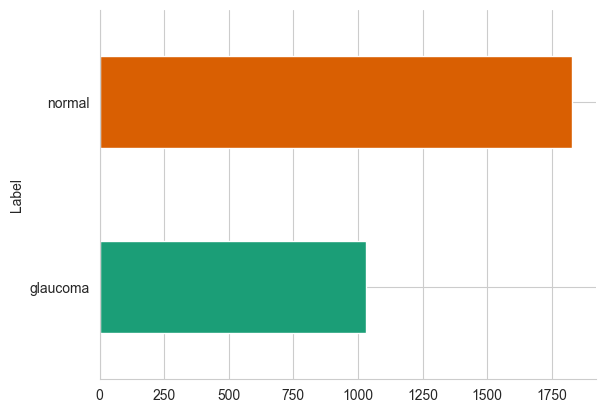

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [34]:
print("Found Label classes: ", df["Label"].unique())

Found Label classes:  ['glaucoma' 'normal']


In [35]:
s=df.copy()
percent_dict={}
N=s.shape[0]
for i in s["Label"].unique():
    d=s.loc[s["Label"]==i]
    n=d.shape[0]
    p=n/N*100
    percent_dict[i]=p

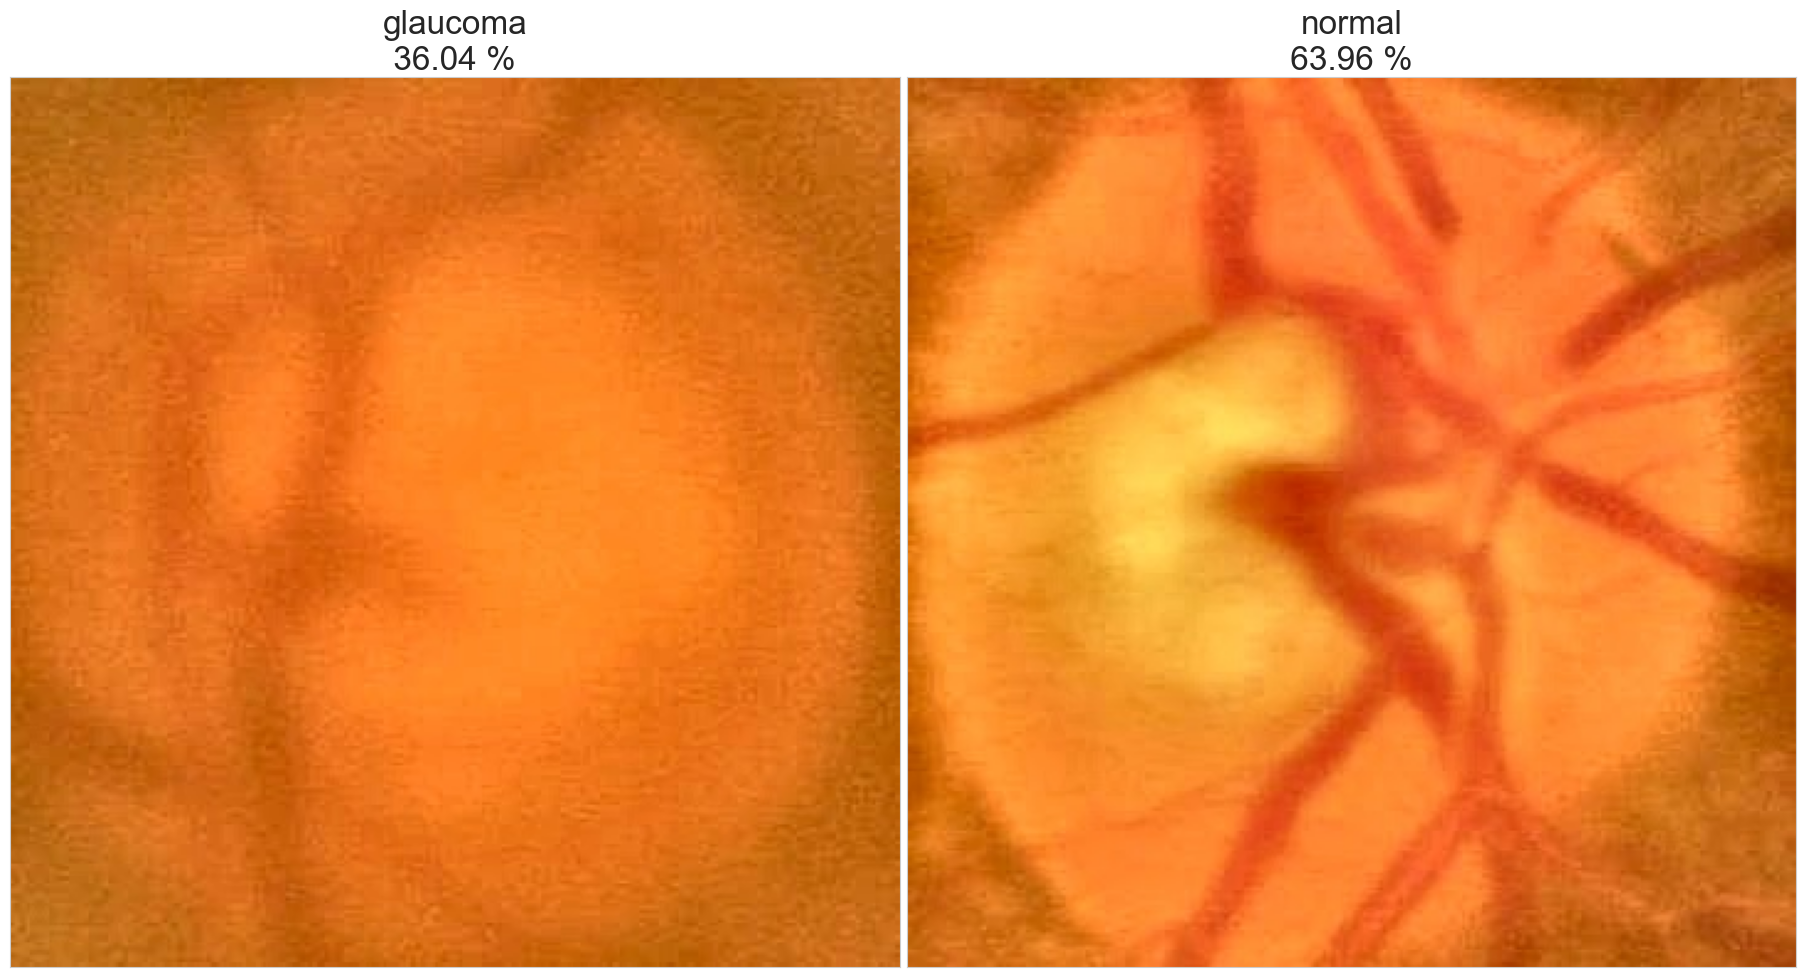

In [36]:
# Percentuálny pomer zastúpenia zdravých a glaukomových ochorení v zloženom súbore údajov

df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i]+"\n {} % ".format(round(percent_dict[df_unique.Label[i]],2))
                 , fontsize = 24)
plt.tight_layout(pad=0.5)
plt.show()

In [37]:
import pandas as pd

# Vyváženie súboru údajov nadvzorkovaním menšinovej triedy ("glaucomam") tak, aby sa počet vzoriek zhodoval s počtom vzoriek vo väčšinovej triede ("normal").

total_samples = 4000
num_normal_samples = total_samples // 2
num_glaucoma_samples = total_samples - num_normal_samples

normal_data = df[df["Label"] == "normal"]
glaucoma_data = df[df["Label"] == "glaucoma"]

oversampled_glaucoma_data = glaucoma_data.sample(n=num_glaucoma_samples, replace=True)

oversampled_normal_data = normal_data.sample(n=num_normal_samples, replace=True)

balanced_df = pd.concat([oversampled_glaucoma_data, oversampled_normal_data])

sample = balanced_df.sample(frac=1).reset_index(drop=True)

In [38]:
num_normal_samples = (sample["Label"] == "normal").sum()
num_glaucoma_samples = (sample["Label"] == "glaucoma").sum()

print("Number of samples for 'normal_onh' class:", num_normal_samples)
print("Number of samples for 'glaucoma_onh' class:", num_glaucoma_samples)

Number of samples for 'normal_onh' class: 2000
Number of samples for 'glaucoma_onh' class: 2000


In [39]:
s=sample.copy()
percent_dict={}
N=s.shape[0]
for i in s["Label"].unique():
    d=s.loc[s["Label"]==i]
    n=d.shape[0]
    p=n/N*100
    percent_dict[i]=p

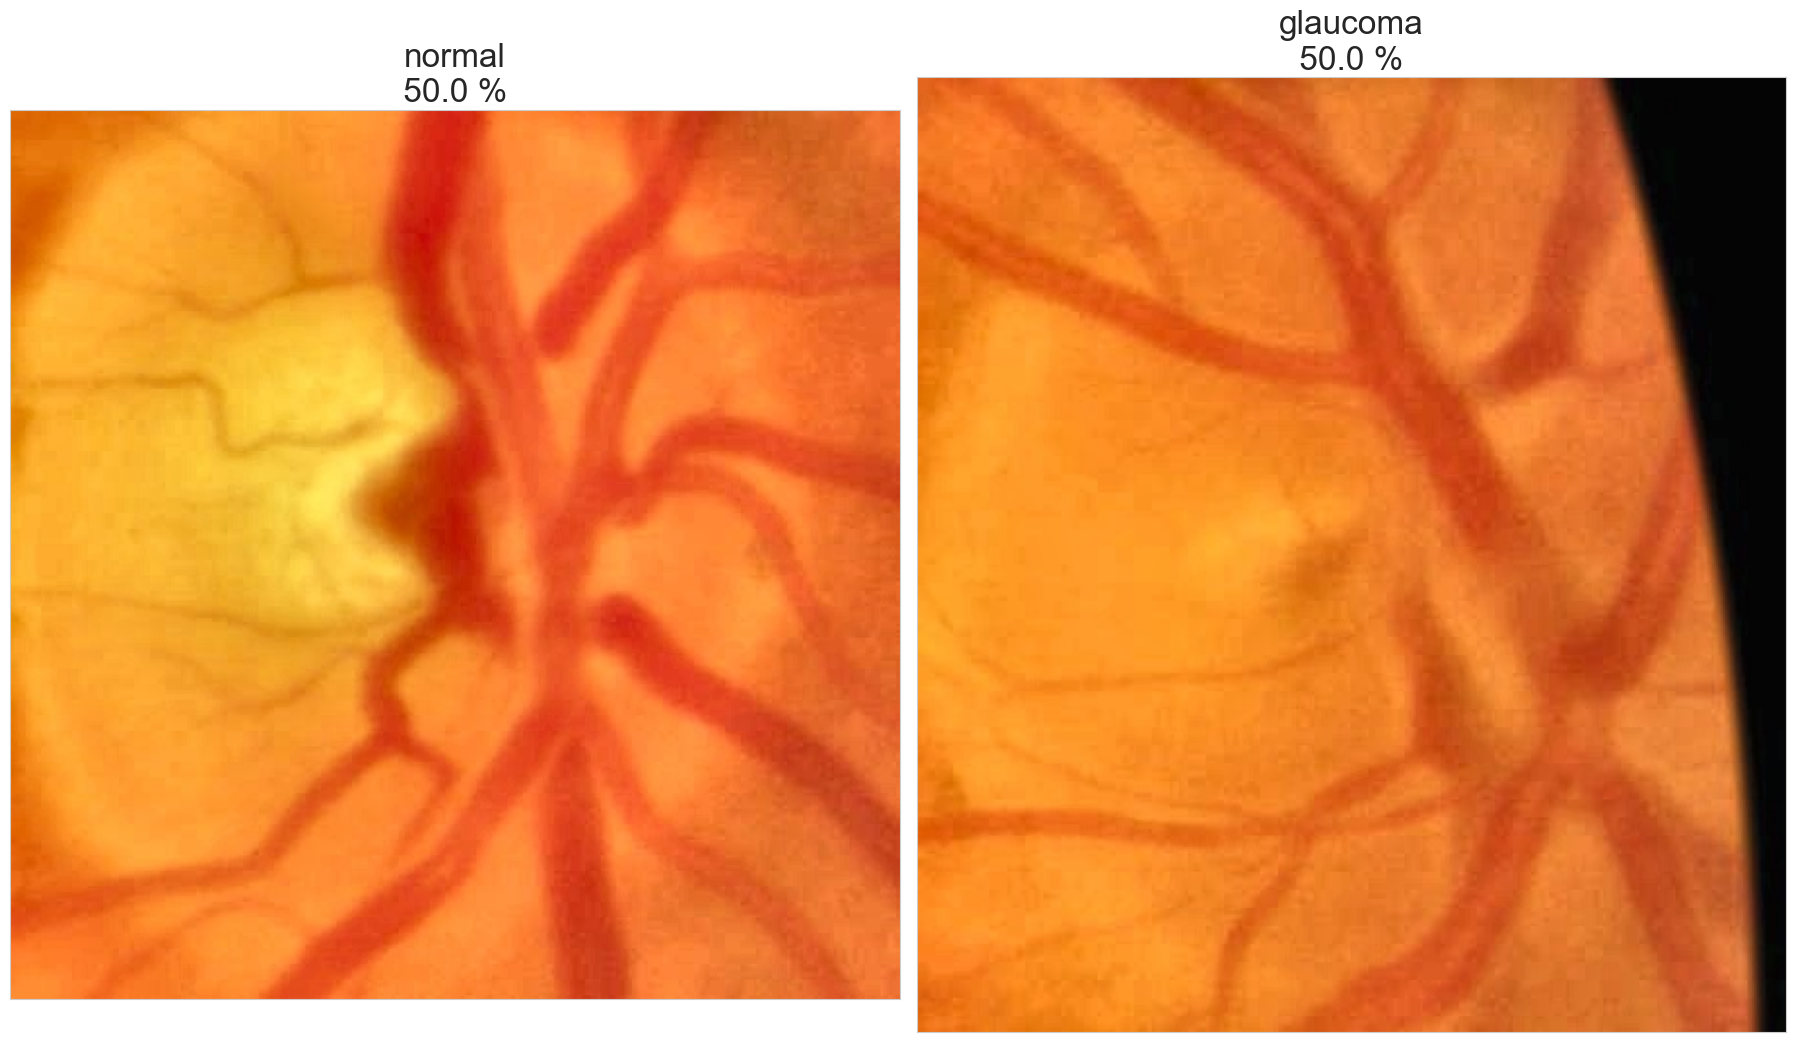

In [40]:
# Percentuálny pomer zastúpenia zdravých a glaukomových ochorení v zloženom súbore údajov po nadvzorkovani a podvzorkovaní

df_unique = sample.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i]+"\n {} % ".format(round(percent_dict[df_unique.Label[i]],2))
                 , fontsize = 24)
plt.tight_layout(pad=0.5)
plt.show()

In [41]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
import pandas as pd
from PIL import Image, ImageOps
import cv2
import numpy as np

In [42]:
def preprocess_images(path):
    """
    Funkcia aplikujúca rôzne kroky predbežného spracovania obrazu.

    Args:
    - (str): Cesta k vstupnému obrazu.

    Returns:
    - img (pole): Predspracované pole obrazov.
    """

    preprocessed_fundus_image = cv2.imread(path)
    preprocessed_fundus_image = cv2.resize(preprocessed_fundus_image, (224, 224), interpolation=cv2.INTER_CUBIC)

    preprocessed_fundus_image = cv2.fastNlMeansDenoisingColored(preprocessed_fundus_image, None, 10, 10, 7, 21)
    preprocessed_fundus_image = ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(preprocessed_fundus_image),cutoff=5))
    preprocessed_fundus_image = img_to_array(preprocessed_fundus_image)
    preprocessed_fundus_image = cv2.GaussianBlur(preprocessed_fundus_image, (5, 5) ,0)
    preprocessed_fundus_image = preprocess_input(preprocessed_fundus_image)
    return preprocessed_fundus_image

In [43]:
model = ResNet50(weights='imagenet',include_top=False,pooling="avg")

In [44]:
def extract_features(img):
    """
    Funkcia aplikujúca extrakciu príznakov pomocou predtrénovaného modelu ResNet50.

    Args:
    - img (PIL.Image): Vstupný obraz.

    Returns: Image (obraz):
    - výstup (zoznam): Extrahované príznaky.
    """

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    features = model.predict(x)
    output = [p.flatten() for p in features]
    return list(output[0])

In [45]:
original_image = cv2.imread(sample["Filepath"].values[0])
image_bgr = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_bgr, (224, 224),interpolation=cv2.INTER_CUBIC)
image_denoise = cv2.fastNlMeansDenoisingColored(image_resized, None, 10, 10, 7, 21)
image_contrast = np.array(ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(image_denoise), cutoff=5)))
image_gaussian = cv2.GaussianBlur(image_contrast, (5, 5), 0)
image_arr = img_to_array(image_gaussian)
image_preprocess = preprocess_input(image_arr)

(-0.5, 223.5, 223.5, -0.5)

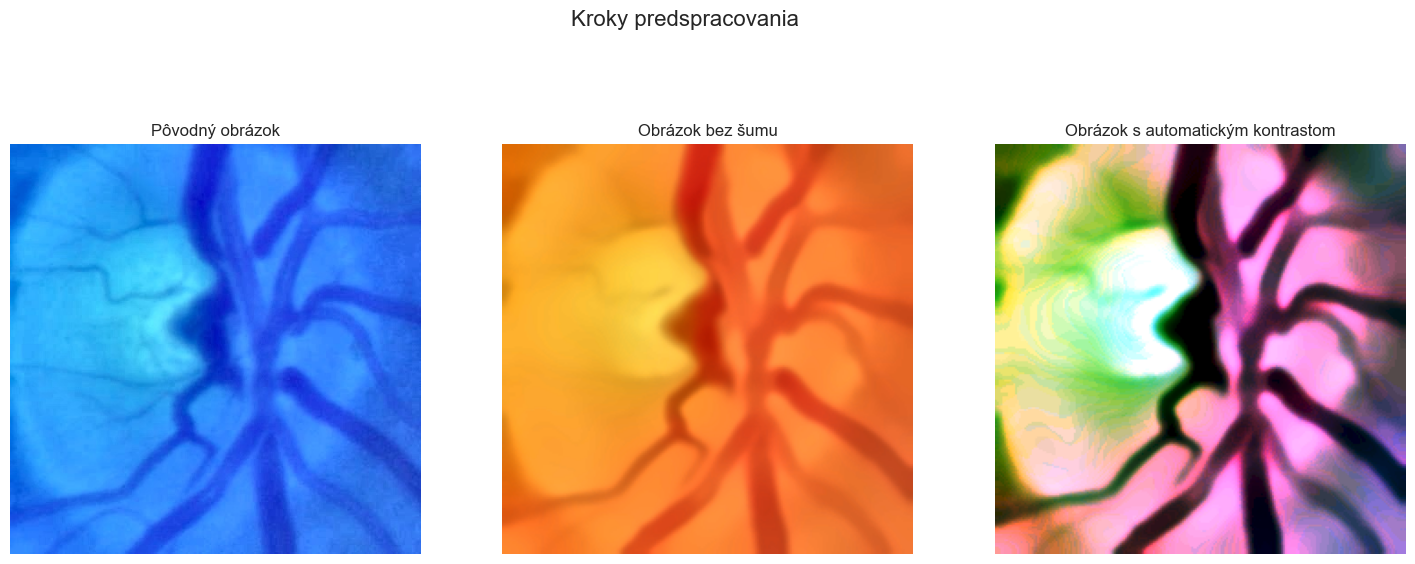

In [46]:
# Vizualizácia krokov predspracovania

fig=plt.figure(figsize=[18,7])
plt.suptitle("Kroky predspracovania",size=16)
plt.subplot(1,3,1)
plt.title("Pôvodný obrázok")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Obrázok bez šumu")
plt.imshow(image_denoise)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Obrázok s automatickým kontrastom")
plt.imshow(image_contrast)
plt.axis('off')

In [47]:
from tqdm import tqdm

preprocessed_images = []

for filepath in tqdm(sample["Filepath"], total=len(sample)):
    preprocessed_images.append(preprocess_images(filepath))

sample["Preprocessed images"] = preprocessed_images

100%|██████████| 4000/4000 [20:07<00:00,  3.31it/s]


In [48]:
sample["Features"] = sample["Preprocessed images"].apply(extract_features)

1/1 [==============================] - 0s 20ms/step


In [49]:
print(sample.shape)

(4000, 4)


Extracted features from ResNet50:
0       [5.217292, 0.0, 0.1742672, 0.0, 0.055959336, 0...
1       [3.0577717, 0.0030465734, 0.009281978, 0.0, 0....
2       [1.0882336, 0.45426252, 0.9328637, 0.0, 0.0193...
3       [2.199989, 0.008875132, 0.31037536, 0.0, 0.773...
4       [2.8235683, 0.082763225, 0.54607844, 0.0, 0.22...
                              ...                        
3995    [2.1209583, 0.0, 0.043287553, 0.0, 0.41739526,...
3996    [1.9794391, 0.047781233, 0.0, 0.018308097, 0.2...
3997    [1.223001, 0.9749762, 0.096857145, 0.013404878...
3998    [1.7585903, 0.10896581, 0.15162185, 0.0, 0.0, ...
3999    [3.8607388, 0.25510085, 0.14002411, 0.01143729...
Name: Features, Length: 4000, dtype: object


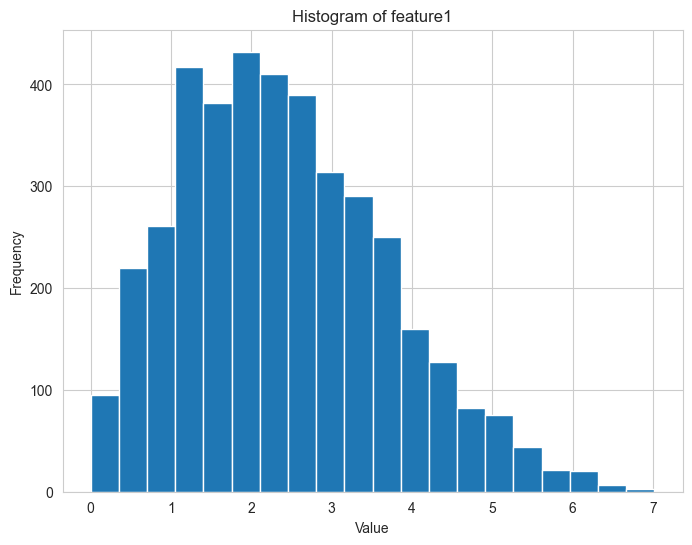

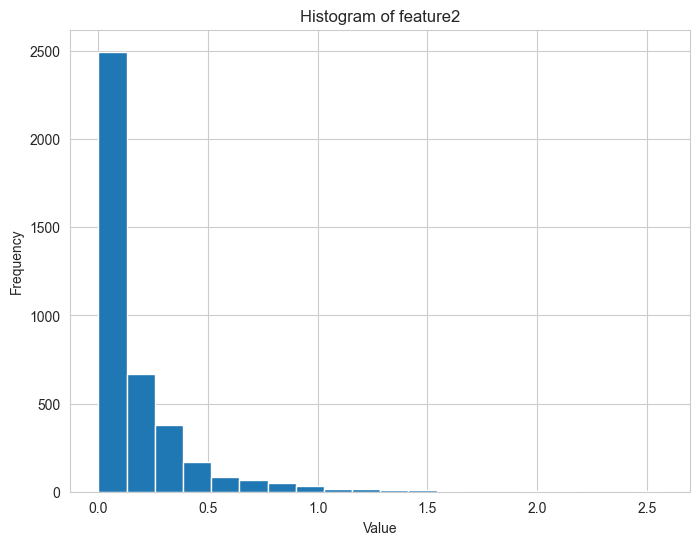

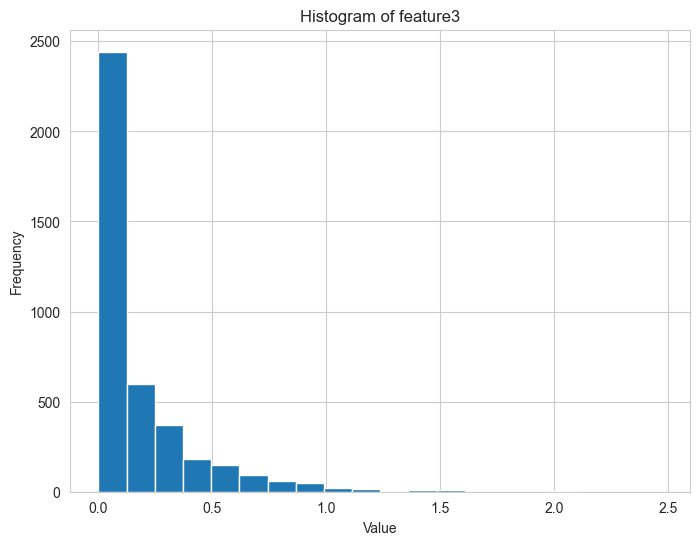

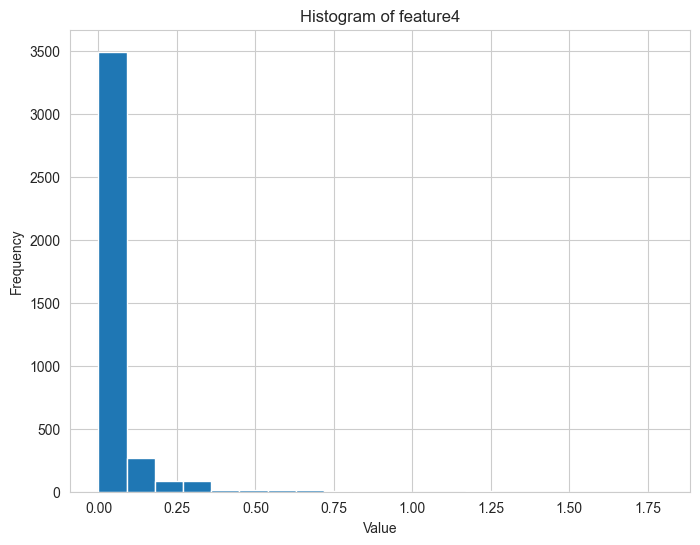

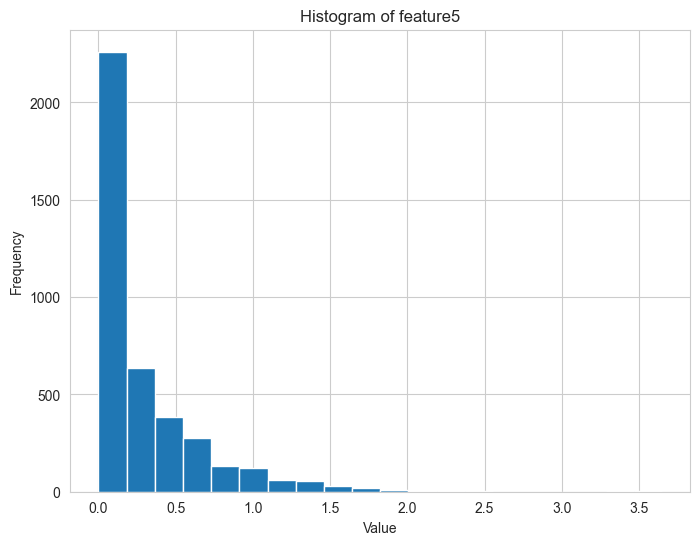

In [50]:
print("Extracted features from ResNet50:")
print(sample["Features"])

# Vizualizacia extrahovaých príznakov

num_features_to_visualize = 5
for i in range(num_features_to_visualize):
    feature_name = "feature{}".format(i+1)
    plt.figure(figsize=(8, 6))
    plt.hist(sample["Features"].apply(lambda x: x[i]), bins=20)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of {}".format(feature_name))
    plt.show()

In [51]:
sample.to_csv("output_after_preprocessing.csv", index=False)

In [52]:
#sample = pd.read_csv("output_after_preprocessing.csv")

In [53]:
for i in range(0,len(sample["Features"].values[0])):
    def format_features(val):
        x=val[i]
        return x
    sample["feature{}".format(i+1)]=sample["Features"].apply(format_features)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8464\3533284626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample["feature{}".format(i+1)]=sample["Features"].apply(format_features)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8464\3533284626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample["feature{}".format(i+1)]=sample["Features"].apply(format_features)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8464\3533284626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [54]:
sample.head()

Filepath     Label  \
0    clahe_images_cropped\normal\image_3137.jpg    normal   
1  clahe_images_cropped\glaucoma\image_1233.jpg  glaucoma   
2  clahe_images_cropped\glaucoma\image_3026.jpg  glaucoma   
3    clahe_images_cropped\normal\image_2947.jpg    normal   
4    clahe_images_cropped\normal\image_2570.jpg    normal   

                                 Preprocessed images  \
0  [[[-50.939003, -29.779, -123.68], [-50.939003,...   
1  [[[20.060997, -27.279, -61.21125], [18.560997,...   
2  [[[-47.939003, -69.779, -81.68], [-47.939003, ...   
3  [[[-38.939003, -59.779, -55.68], [-38.689003, ...   
4  [[[-35.376503, -46.779, -123.68], [-34.689003,...   

                                            Features  feature1  feature2  \
0  [5.217292, 0.0, 0.1742672, 0.0, 0.055959336, 0...  5.217292  0.000000   
1  [3.0577717, 0.0030465734, 0.009281978, 0.0, 0....  3.057772  0.003047   
2  [1.0882336, 0.45426252, 0.9328637, 0.0, 0.0193...  1.088234  0.454263   
3  [2.199989, 0.008875132, 0.31037536, 0.0, 0.773...  2.199989  0.008875   
4  [2.8235683, 0.082763225, 0.54607844, 0.0, 0.22...  2.823568  0.082763   

   feature3  feature4  feature5  feature6  ...  feature2039  feature2040  \
0  0.174267       0.0  0.055959  0.000000  ...     2.501229     0.866511   
1  0.009282       0.0  0.303039  0.390016  ...     1.904268     0.570534   
2  0.932864       0.0  0.019342  0.000000  ...     0.822521     0.289351   
3  0.310375       0.0  0.773208  0.027392  ...     1.667204     0.317502   
4  0.546078       0.0  0.225259  0.000000  ...     0.791870     0.188375   

   feature2041  feature2042  feature2043  feature2044  feature2045  \
0     0.453848     0.000000     0.019996     0.759079     0.000000   
1     0.097303     0.705517     0.109663     0.281234     0.005834   
2     0.477136     0.000000     0.075189     0.108687     0.057117   
3     0.940341     0.000000     0.142674     0.013235     0.000000   
4     0.000000     0.000000     0.086167     0.032941     0.000000   

   feature2046  feature2047  feature2048  
0     0.000000     0.254559     0.000000  
1     0.000000     0.841838     0.000000  
2     1.030961     0.866597     0.297036  
3     0.203795     2.530217     0.362333  
4     0.388818     3.221749     0.000000  

[5 rows x 2052 columns]

Text(0, 0.5, 'explained_variance_ratio_')

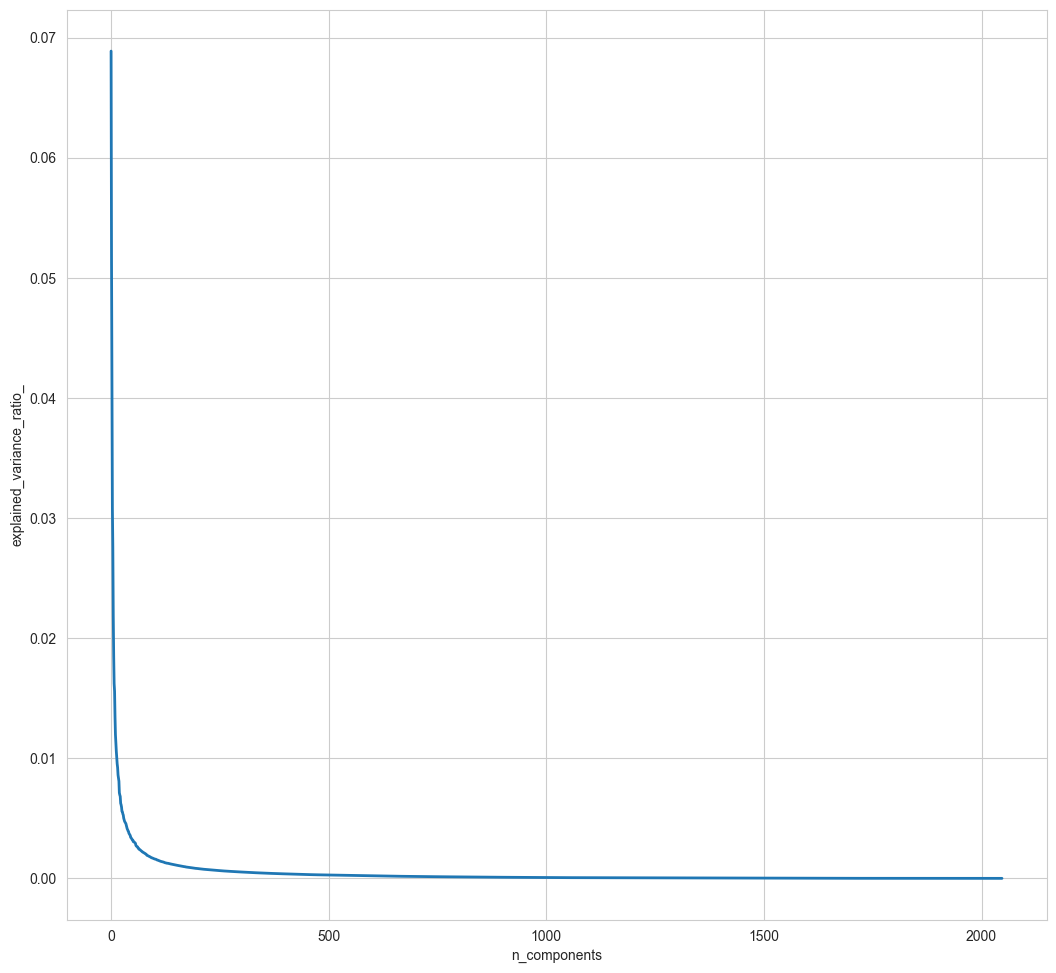

In [55]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# Redukcia dimenzionality použitím PCA

features = sample.drop(columns=['Filepath', 'Label', 'Preprocessed images', 'Features'])
scaler = StandardScaler()
ss = scaler.fit_transform(features)

pca = decomposition.PCA(n_components=min(features.shape[1],
                                             features.shape[0])).fit(ss)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [56]:
n_components=0
ratio = pca.explained_variance_ratio_
for i in range(features.shape[1]):
    a = ratio.cumsum()[i]
    if a >= 0.8:
        print("{} principal components explains 80% of variance ratio.".format(i))
        n_components=i
        break

250 principal components explains 80% of variance ratio.


In [57]:
pca = decomposition.PCA(n_components=n_components)
d=pca.fit_transform(ss)
d=pd.DataFrame(d, columns=["PCA n°{}".format(i+1) for i in range(0,n_components) ])
d["Label"]=sample["Label"].values

In [58]:
d.head()

PCA n°1    PCA n°2    PCA n°3    PCA n°4    PCA n°5    PCA n°6  \
0 -10.266524   4.175944   5.854338   4.205651   6.214533 -12.018751   
1  -3.653626   3.055413  14.001664   2.324607   5.091165  15.868098   
2  10.609627  21.740498 -11.775350 -19.705090 -15.034023  30.095173   
3  -2.414588  26.208584  -5.856086  -8.182034   1.383280   5.648736   
4 -13.084241   6.235644  -9.588503   7.369667   1.178756   1.338143   

     PCA n°7    PCA n°8   PCA n°9  PCA n°10  ...  PCA n°242  PCA n°243  \
0   4.347658   1.782395  4.721970  2.499318  ...   0.666824  -1.050895   
1   6.084315   7.733677  3.531260  3.767901  ...  -1.049672   0.713756   
2  12.493893  13.665881  1.397812  6.161975  ...   2.066036   3.859986   
3  -2.999171   4.301189  7.682690  5.755133  ...   3.093550   2.359004   
4 -11.981394  -4.560922  3.216508 -3.288667  ...   0.110089   0.053200   

   PCA n°244  PCA n°245  PCA n°246  PCA n°247  PCA n°248  PCA n°249  \
0  -0.048284   0.301597   0.243547  -1.494745  -0.443370  -1.380703   
1  -0.924944   1.617762  -0.488222   0.213112  -2.322495   2.776640   
2  -2.514049   2.110645   1.868110   0.828390   2.080647   3.070927   
3  -2.908017  -1.433164  -1.111853  -0.968638   0.646084  -1.079644   
4   0.936487  -0.956657   0.871038  -0.048697   1.471064  -0.412539   

   PCA n°250     Label  
0  -0.396089    normal  
1   1.424863  glaucoma  
2   0.859942  glaucoma  
3  -0.345889    normal  
4   0.775237    normal  

[5 rows x 251 columns]

In [59]:
d.to_csv("output_images_cropped.csv", index=False)

In [60]:
#df = pd.read_csv("output.csv")

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y=d["Label"]
X=d.drop(columns=["Label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.svm import SVC

# Trénovanie strojov s podpornými vektormi

svm = SVC(probability=True)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 300],  # Regularizačný parameter
    'gamma': ['scale'],  # gamma: 'scale', 'auto'
    'kernel': ['rbf']   # Funkcia jadra: 'rbf', 'poly', and 'sigmoid'
}

# 3-krížová validácia s prehľadavaním mriežky (najlepšie hyperparametre)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
grid_search.fit(scaled_train,y_train) 
svm_best = grid_search.best_estimator_
pred = svm_best.predict(scaled_test)
score= accuracy_score(y_test,pred)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END ......................C=10, gamma=scale,

In [63]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [64]:
svm = SVC(C=100, kernel='rbf', gamma='scale')

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_svm = svm.fit(scaled_train,y_train) 

pred_one = model_svm.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [65]:
print("Accuracy score:", round(score,4)," on the testing set with SVM.")

Accuracy score: 0.91  on the testing set with SVM.


In [66]:
from sklearn.metrics import classification_report

print("SVM Classifier Report:")
print(classification_report(y_test, pred, digits=4))

SVM Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.8946    0.9264    0.9102       394
      normal     0.9260    0.8941    0.9098       406

    accuracy                         0.9100       800
   macro avg     0.9103    0.9102    0.9100       800
weighted avg     0.9105    0.9100    0.9100       800


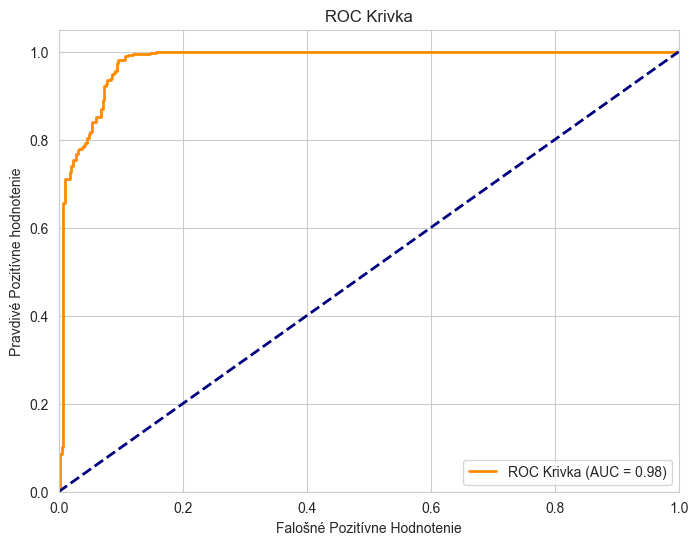

In [67]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Výpočet a vizualizácia ROC-AUC krivky

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = svm_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_svm, tpr_svm, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

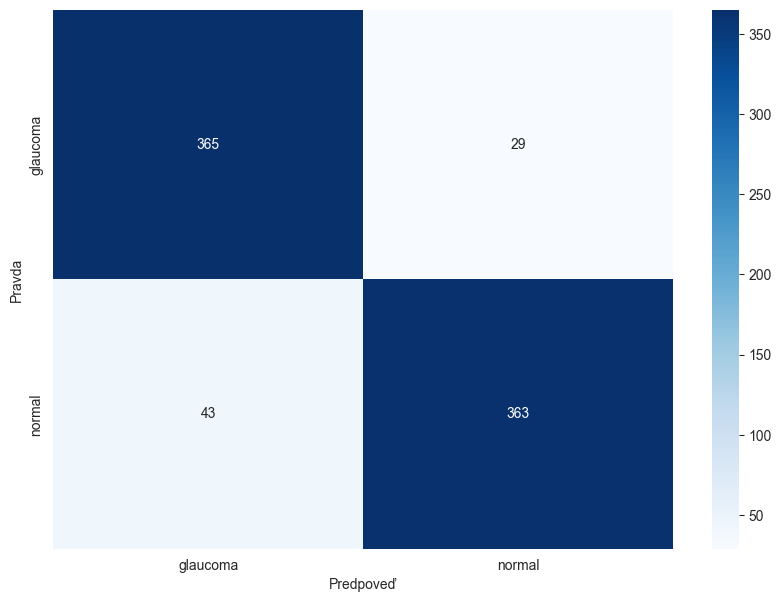

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Vizualizácia konfúznej matice

cm = confusion_matrix(y_test,pred)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_best.classes_, yticklabels=svm_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

RANDOM FORREST

In [69]:
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 300],   # Počet stromov
    'max_depth': [10, 20],      # Hĺbka stromu
    'max_features': ['sqrt', 'log2']  # Počet funkcií, ktoré treba zohľadniť pri každom rozdelení
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_rf.fit(scaled_train,y_train)
rf_best = grid_search_rf.best_estimator_
pred_rf = rf_best.predict(scaled_test)
score2 = accuracy_score(y_test,pred_rf)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   2.0s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   2.0s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   2.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   4.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   4.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   4.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=  12.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=  12.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=  12.4s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.9s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.9s
[CV] END ...max_depth=10, max_features=log2, n_e

In [70]:
best_params = grid_search_rf.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}


In [71]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None)

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_rf = rf.fit(scaled_train,y_train) 

pred_one = model_rf.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [72]:
print("Accuracy score:", round(score2,4)," on the testing set with random forest.")

Accuracy score: 0.9175  on the testing set with random forest.


In [73]:
print("Random Forest Classifier Report:")
print(classification_report(y_test, pred_rf, digits=4))

Random Forest Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.9162    0.9162    0.9162       394
      normal     0.9187    0.9187    0.9187       406

    accuracy                         0.9175       800
   macro avg     0.9175    0.9175    0.9175       800
weighted avg     0.9175    0.9175    0.9175       800


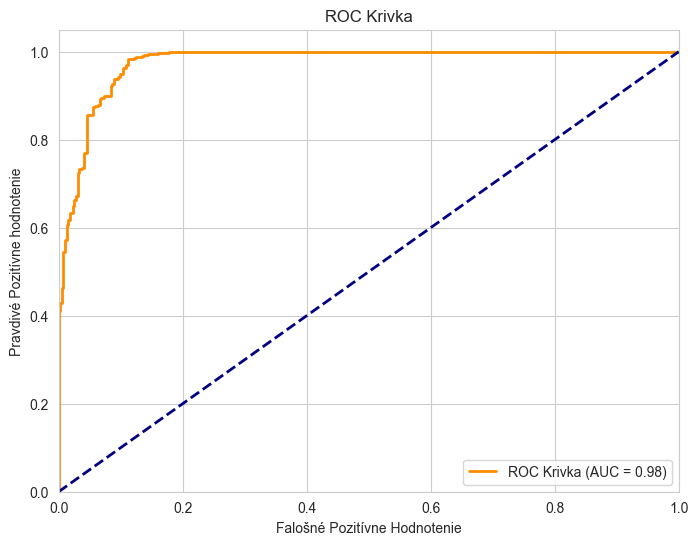

In [74]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Výpočet a vizualizácia ROC-AUC krivky

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = rf_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

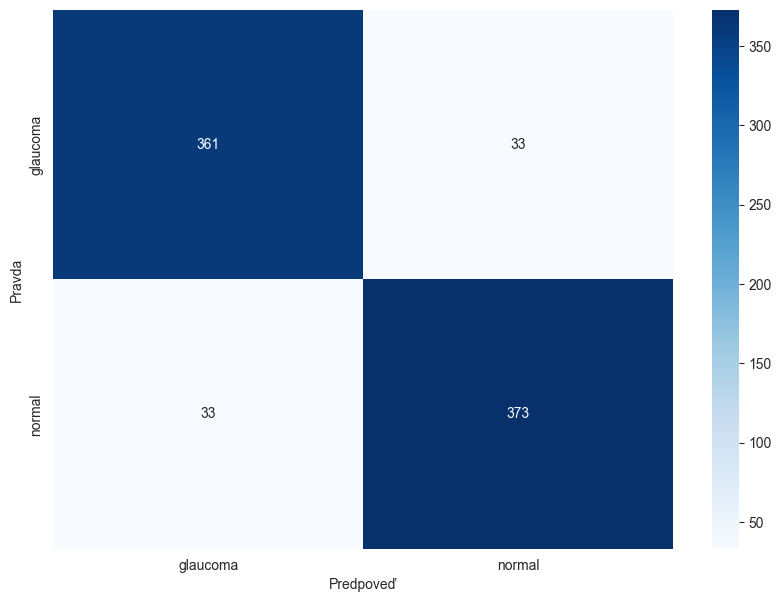

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Vizualizácia konfúznej matice

cm = confusion_matrix(y_test,pred_rf)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_best.classes_, yticklabels=rf_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

Logistic Regression

In [76]:
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l2'],   # Penalizácia
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularizačná sila
}

lr = LogisticRegression()
ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_lr.fit(scaled_train, y_train)
lr_best = grid_search_lr.best_estimator_
pred_lr = lr_best.predict(scaled_test)
score3 = accuracy_score(y_test,pred_lr)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1,

In [77]:
best_params = grid_search_lr.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'penalty': 'l2'}


In [78]:
lr = LogisticRegression(C=10, penalty='l2')
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_lr = lr.fit(scaled_train,y_train) 

pred_one = model_lr.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [79]:
print("Accuracy score:", round(score3,4)," on the testing set with logistic regression.")

Accuracy score: 0.7562  on the testing set with logistic regression.


In [80]:
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, pred_lr, digits=4))

Logistic Regression Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.7506    0.7563    0.7535       394
      normal     0.7618    0.7562    0.7590       406

    accuracy                         0.7562       800
   macro avg     0.7562    0.7563    0.7562       800
weighted avg     0.7563    0.7562    0.7563       800


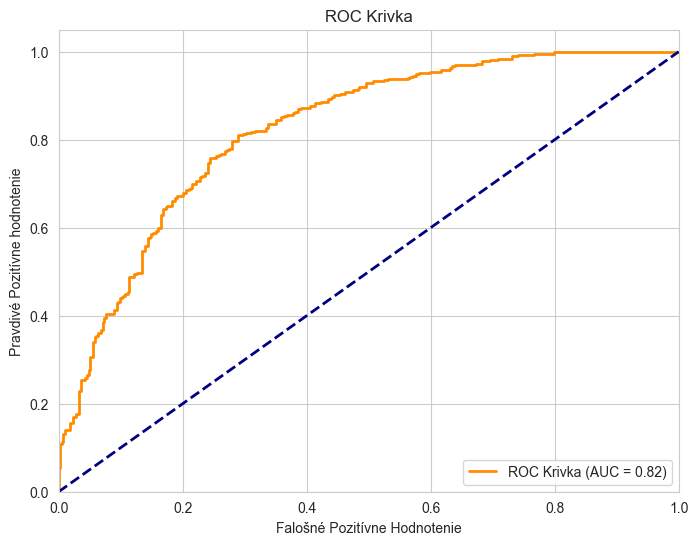

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = lr_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_lr, tpr_lr, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

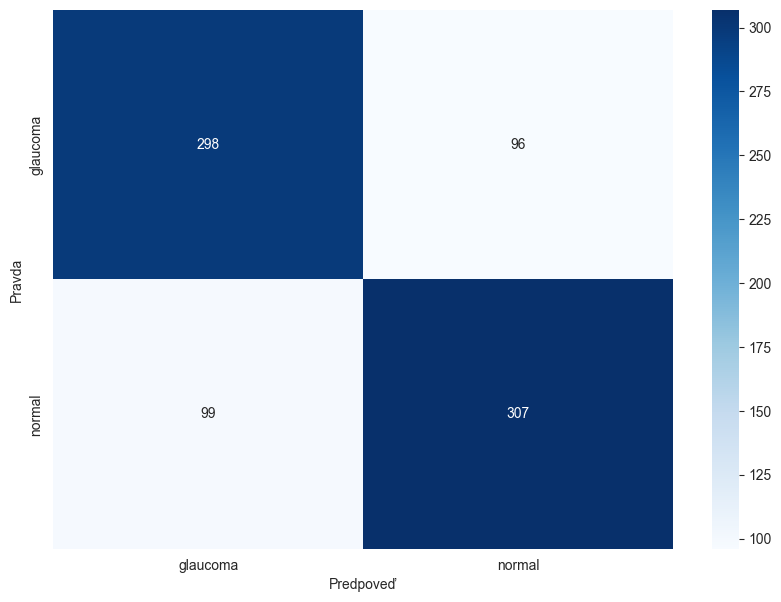

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_lr)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_best.classes_, yticklabels=lr_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

KNN

In [83]:
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 31),   # Počet susedov
    'weights': ['uniform', 'distance'],   # Váhova funkcia na predikciu
}

knn = KNeighborsClassifier()
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_knn.fit(scaled_train, y_train)
knn_best = grid_search_knn.best_estimator_
pred_knn = knn_best.predict(scaled_test)
score5 = accuracy_score(y_test,pred_knn)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, wei

In [84]:
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_neighbors': 29, 'weights': 'distance'}


In [85]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_knn = knn.fit(scaled_train,y_train) 

pred_one = model_knn.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [86]:
print("Accuracy score:", round(score5,4)," on the testing set with KNeighbors.")

Accuracy score: 0.9062  on the testing set with KNeighbors.


In [87]:
print("KNN Classifier Report:")
print(classification_report(y_test, pred_knn, digits=4))

KNN Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.8843    0.9315    0.9073       394
      normal     0.9299    0.8818    0.9052       406

    accuracy                         0.9062       800
   macro avg     0.9071    0.9066    0.9062       800
weighted avg     0.9074    0.9062    0.9062       800


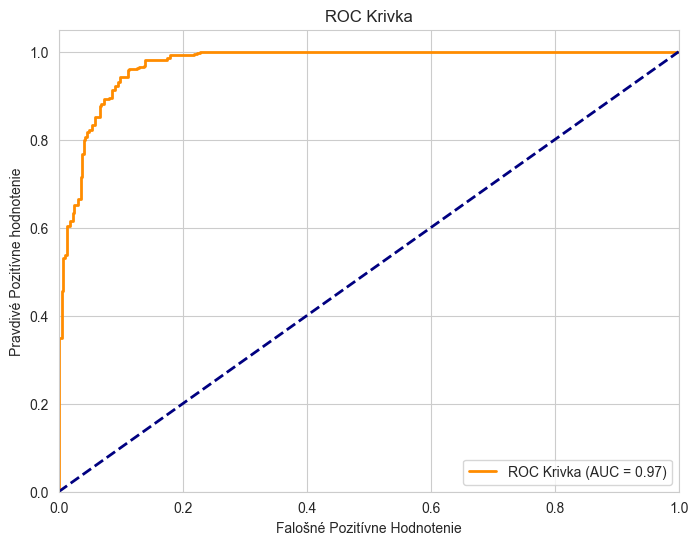

In [88]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = knn_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_knn, tpr_knn, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

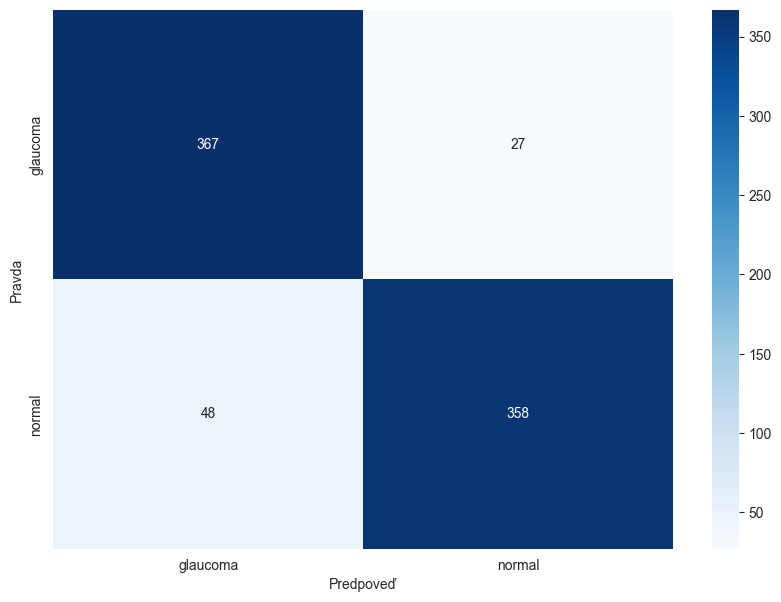

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_knn)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn_best.classes_, yticklabels=knn_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

In [90]:
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import AdaBoostClassifier

base_estimators = [rf_best, svm_best, lr_best]

param_grid = {
    'estimator': base_estimators,   # Základný slabý klasifikátor
    'n_estimators': [50, 100]       # Počet klasifikátorov
}

ab = AdaBoostClassifier()
ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_ab = GridSearchCV(estimator=ab, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_ab.fit(scaled_train, y_train)
ab_best = grid_search_ab.best_estimator_
pred_ab = ab_best.predict(scaled_test)
score4 = accuracy_score(y_test,pred_ab)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END estimator=RandomForestClassifier(max_depth=20, n_estimators=300), n_estimators=50; total time=  16.3s
[CV] END estimator=RandomForestClassifier(max_depth=20, n_estimators=300), n_estimators=50; total time=  16.1s
[CV] END estimator=RandomForestClassifier(max_depth=20, n_estimators=300), n_estimators=50; total time=  15.8s
[CV] END estimator=RandomForestClassifier(max_depth=20, n_estimators=300), n_estimators=100; total time=  16.1s
[CV] END estimator=RandomForestClassifier(max_depth=20, n_estimators=300), n_estimators=100; total time=  16.0s
[CV] END estimator=RandomForestClassifier(max_depth=20, n_estimators=300), n_estimators=100; total time=  15.7s
[CV] END estimator=SVC(C=10, probability=True), n_estimators=50; total time= 2.0min
[CV] END estimator=SVC(C=10, probability=True), n_estimators=50; total time= 2.2min
[CV] END estimator=SVC(C=10, probability=True), n_estimators=50; total time= 2.0min
[CV] END estimator=

In [91]:
best_params = grid_search_ab.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'estimator': RandomForestClassifier(max_depth=20, n_estimators=300), 'n_estimators': 50}


In [92]:
ab = AdaBoostClassifier(estimator=lr_best, n_estimators=10)
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_ab = ab.fit(scaled_train,y_train) 

pred_one = model_ab.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [93]:
print("Accuracy score:", round(score4,4)," on the testing set with AdaBoost.")

Accuracy score: 0.9288  on the testing set with AdaBoost.


In [94]:
# Print classification reports
print("AdaBoost Classifier Report:")
print(classification_report(y_test, pred_ab, digits=4))

AdaBoost Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.9332    0.9213    0.9272       394
      normal     0.9246    0.9360    0.9302       406

    accuracy                         0.9287       800
   macro avg     0.9289    0.9286    0.9287       800
weighted avg     0.9288    0.9287    0.9287       800


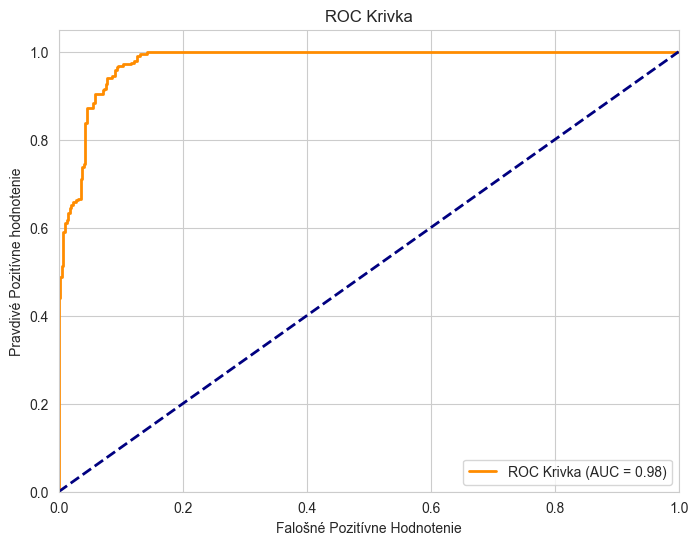

In [95]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = ab_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_ab, tpr_ab, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_ab = auc(fpr_ab, tpr_ab)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_ab)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

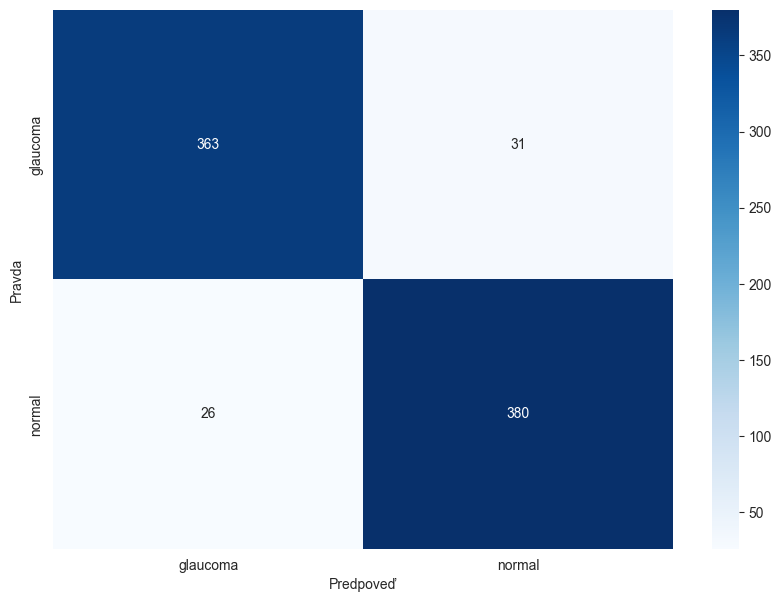

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_ab)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ab_best.classes_, yticklabels=ab_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

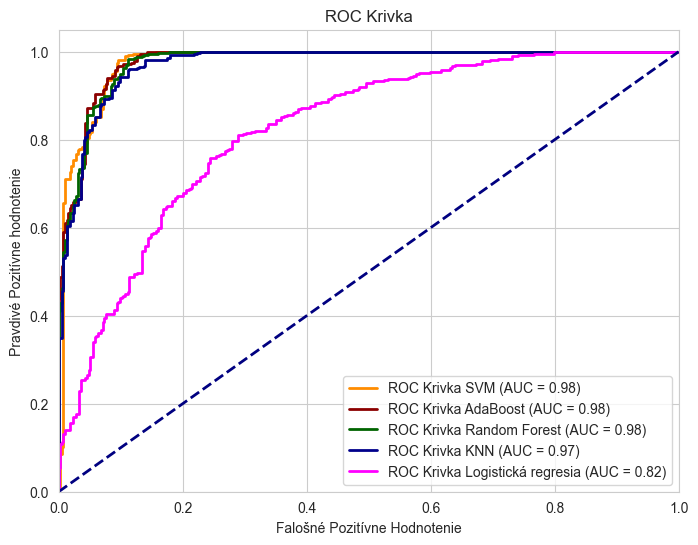

In [97]:
# ROC-AUC krivka pre všetký klasifikátory
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC Krivka SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_ab, tpr_ab, color='darkred', lw=2, label='ROC Krivka AdaBoost (AUC = %0.2f)' % roc_auc_ab)
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='ROC Krivka Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_knn, tpr_knn, color='darkblue', lw=2, label='ROC Krivka KNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_lr, tpr_lr, color='magenta', lw=2, label='ROC Krivka Logistická regresia (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()